# []

In [2]:
# inbuilt 
import os
import sys
import math

# most common
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch as tt
import torch.nn as nn
import torch.optim as oo
import torch.functional as ff
import torch.distributions as dd
import torch.utils.data as ud

# custom
import known
from known.basic import pj
from known.basic.common import Verbose as verb
import known.ktorch as kt

print(f'{sys.version=}\n{np.__version__=}\n{tt.__version__=}\n{known.__version__=}')

sys.version='3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]'
np.__version__='1.22.2'
tt.__version__='1.10.1+cu102'
known.__version__='0.0.1'


In [3]:
a = kt.arange((3,5))
a

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

In [5]:
b=a.unsqueeze(1)
b.shape, b

(torch.Size([3, 1, 5]),
 tensor([[[ 0,  1,  2,  3,  4]],
 
         [[ 5,  6,  7,  8,  9]],
 
         [[10, 11, 12, 13, 14]]]))

# Select DataSet

In [1]:
a,b,c = 0, (1,2)
a,b,c

ValueError: not enough values to unpack (expected 3, got 2)

## (1) Langauge

In [2]:
vocab_words = ['a', 'b']
ds = kt.LangDataset(vocab_words, embed=1, dtype=tt.float32)

ds.add_class('astr', 'bstr', 'mixed')

rng = np.random.default_rng(12)
num_words = 6

ds.add_samples('astr', *[verb.strN('a', rng.integers(6, 12)) for _ in range(num_words)])
ds.add_samples('bstr', *[verb.strN('b', rng.integers(6, 12)) for _ in range(num_words)])
ds.add_samples('mixed',*[ 'ab'.join(['a' if rng.random()>0.5 else 'b' for _ in range(rng.integers(2, 4))]) for _ in range(num_words)])
ds

In [3]:
for index, (l, (xs, ys), (xv, yv)) in enumerate(zip(ds.data_labels, ds.data_str, ds.data)):
    #print(f"[{index}]:: class:{l}:{ys}:{yv}\n sample:{xs}:{xv}")
    print(f"[{index}]\t{l}:{ys}\t{xs}")

[0]	0:astr	aaaaaaaaa
[1]	0:astr	aaaaaaa
[2]	0:astr	aaaaaaaaaaa
[3]	0:astr	aaaaaaaaaaa
[4]	0:astr	aaaaaa
[5]	0:astr	aaaaaaa
[6]	1:bstr	bbbbbbb
[7]	1:bstr	bbbbbbb
[8]	1:bstr	bbbbbbbbb
[9]	1:bstr	bbbbbbbb
[10]	1:bstr	bbbbbbbb
[11]	1:bstr	bbbbbbb
[12]	2:mixed	babaaba
[13]	2:mixed	babaabb
[14]	2:mixed	babbabb
[15]	2:mixed	aabb
[16]	2:mixed	aabaaba
[17]	2:mixed	aabb


# Define Classifier Network

In [4]:
input_size = ds.vocab.vlen
dt = tt.float32
dropout=0.0
batch_first = True

bidirectional = False
bias = True

output_sizes=[32, 32, ds.n_classes]
hidden_sizes = (32, 32, 32)
stack_output=True
use_rnn=False


## encapsulate rnns

In [5]:
networks = dict(

elman_kt =kt.ELMAN(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=output_sizes,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation= (nn.LogSoftmax,{'dim':-1}),
        hypers=None,
        return_last=True,
        return_hidden=False,
        dtype=dt,
        device=None),


gru_kt = kt.GRU(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=output_sizes,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=(nn.LogSoftmax,{'dim':-1}),
        hypers=None,
        return_last=True,
        return_hidden=False,
        dtype=dt,
        device=None),


lstm_kt = kt.LSTM(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=output_sizes,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=(nn.LogSoftmax,{'dim':-1}),
        hypers=None,
        return_last=True,
        return_hidden=False,
        dtype=dt,
        device=None),


mgu_kt = kt.MGU(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=output_sizes,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=(nn.LogSoftmax,{'dim':-1}),
        hypers=None,
        return_last=True,
        return_hidden=False,
        dtype=dt,
        device=None),


janet_kt = kt.JANET(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=output_sizes,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=(nn.LogSoftmax,{'dim':-1}),
        hypers=None,
        return_last=True,
        return_hidden=False,
        dtype=dt,
        device=None),


)

colors = {k:v for k,v in zip(networks.keys(), \
            ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown' ])}

# (A) Train and Evaluate

elman_kt <class 'known.ktorch.rnn.ELMAN'>
[!] Validation frequency is set but data is not provided, Validation will not be performed
Training samples: [18]
Training batches: [18]
Start Training @ 2023-01-24 02:42:19.035796
-------------------------------------------
[*] Saved@ elman_kt.words
-------------------------------------------
Final Training Loss: [0.0050531997306582825]
End Training @ 2023-01-24 02:42:29.739168, Elapsed Time: [0:00:10.703372]


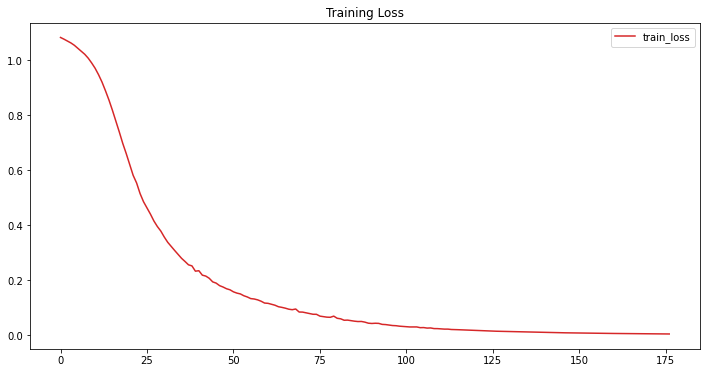

Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.004911258428667982
gru_kt <class 'known.ktorch.rnn.GRU'>
[!] Validation frequency is set but data is not provided, Validation will not be performed
Training samples: [18]
Training batches: [18]
Start Training @ 2023-01-24 02:42:29.864852
-------------------------------------------
[*] Saved@ gru_kt.words
-------------------------------------------
Final Training Loss: [0.004917567401813964]
End Training @ 2023-01-24 02:42:53.781092, Elapsed Time: [0:00:23.916240]


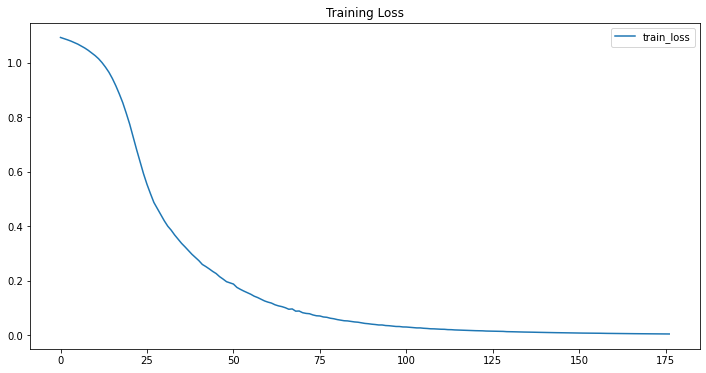

Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.004840079133929167
lstm_kt <class 'known.ktorch.rnn.LSTM'>
[!] Validation frequency is set but data is not provided, Validation will not be performed
Training samples: [18]
Training batches: [18]
Start Training @ 2023-01-24 02:42:53.902996
-------------------------------------------
[*] Saved@ lstm_kt.words
-------------------------------------------
Final Training Loss: [0.003885815335605811]
End Training @ 2023-01-24 02:43:18.304353, Elapsed Time: [0:00:24.401357]


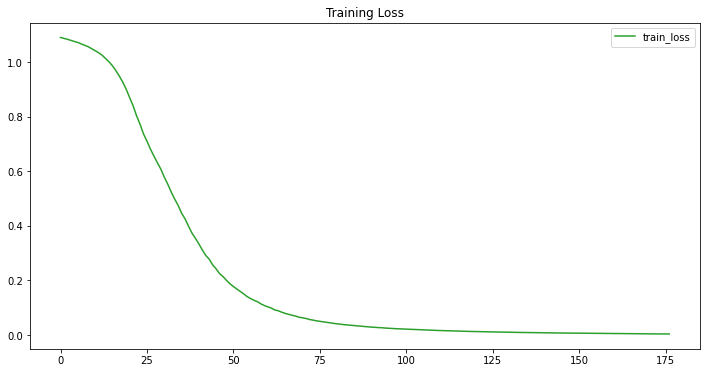

Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.0038503385811863053
mgu_kt <class 'known.ktorch.rnn.MGU'>
[!] Validation frequency is set but data is not provided, Validation will not be performed
Training samples: [18]
Training batches: [18]
Start Training @ 2023-01-24 02:43:18.436146
-------------------------------------------
[*] Saved@ mgu_kt.words
-------------------------------------------
Final Training Loss: [0.003639212395986154]
End Training @ 2023-01-24 02:43:38.049492, Elapsed Time: [0:00:19.613346]


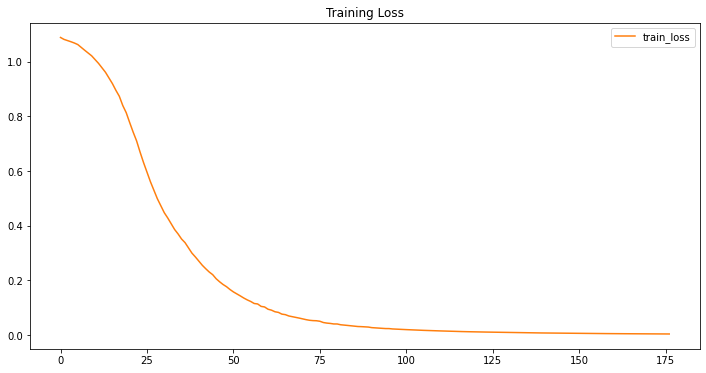

Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.0035707828760172967
janet_kt <class 'known.ktorch.rnn.JANET'>
[!] Validation frequency is set but data is not provided, Validation will not be performed
Training samples: [18]
Training batches: [18]
Start Training @ 2023-01-24 02:43:38.151150
-------------------------------------------
[*] Saved@ janet_kt.words
-------------------------------------------
Final Training Loss: [0.009651450673118234]
End Training @ 2023-01-24 02:43:57.265202, Elapsed Time: [0:00:19.114052]


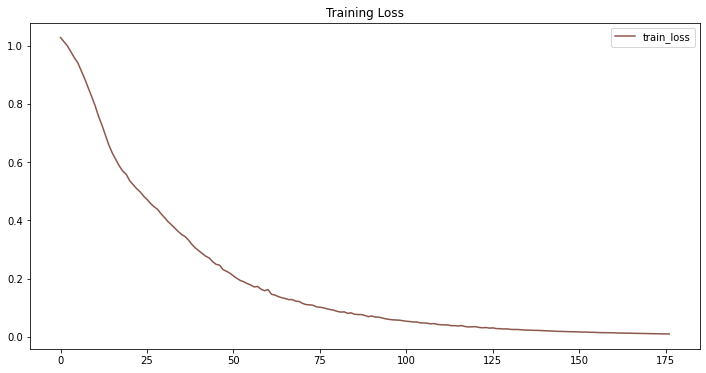

Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.009457494789078029


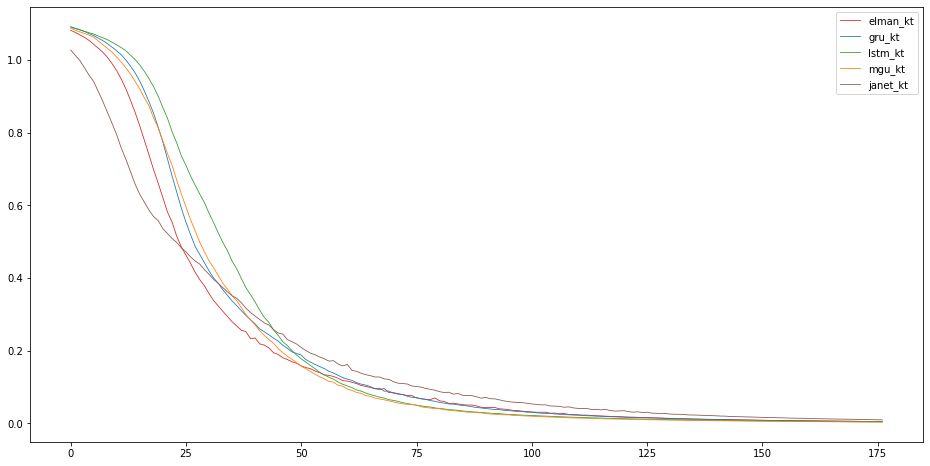

In [6]:
test_loss, train_loss = {}, {}
for key,model in networks.items():
    print(key, model.__class__)
    epochs = num_words*30
    batch_size=1
    shuffle=True
    validation_freq = int(epochs/10)
    criterion=nn.NLLLoss()
    lr = 0.0001
    weight_decay = 0.0
    optimizer=oo.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    lrs=oo.lr_scheduler.LinearLR(optimizer, start_factor= 1.0, end_factor=0.7, total_iters=epochs)

    early_stop_train=kt.QuantiyMonitor('TrainLoss', patience=50, delta=0.00001)
    early_stop_val=kt.QuantiyMonitor('ValLoss', patience=50, delta=0.00001)
    #checkpoint_freq=int(epochs/4)
    save_path=f'{key}.words'
    loss_plot_start = int(epochs/50)

    trainer = kt.Trainer(model)
    trainer.optimizer=optimizer
    trainer.criterion=criterion

    trainer.fit(training_data=ds, validation_data=None, 
                epochs=epochs, batch_size=batch_size,shuffle=shuffle,validation_freq=validation_freq,
                save_path=save_path, use_rnn=use_rnn, verbose=1)

    trainer.plot_results(color=colors[key],loss_plot_start=loss_plot_start)

    mtl, _ = trainer.evaluate(ds, batch_size=1, use_rnn=use_rnn)
    train_loss[key] = np.array(trainer.train_loss_history)
    test_loss[key] = mtl
    print('=================================================')

plt.figure(figsize=(16,8))
for k,v in train_loss.items():
    plt.plot(np.mean(v, axis=1)[loss_plot_start:], label=k, color=colors[k], linewidth=0.8)
plt.legend()
plt.show()

# (B) Load and Evaluate

In [7]:
for key,model in networks.items():
    kt.load_state(model, f'{key}.words')
test_loss={}

for key,model in networks.items():
    trainer = kt.Trainer(model)
    trainer.criterion=nn.NLLLoss() 
    mtl, tl = trainer.evaluate(ds, batch_size=1, use_rnn=use_rnn)

    test_loss[key] = mtl

Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.004911258428667982
Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.004840079133929167
Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.0038503385811863053
Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.0035707828760172967
Testing samples: [18]
Testing batches: [18]
Testing Loss: 0.009457494789078029


# Plot Evaluation Results

elman_kt:	0.004911258428667982
gru_kt:	0.004840079133929167
lstm_kt:	0.0038503385811863053
mgu_kt:	0.0035707828760172967
janet_kt:	0.009457494789078029


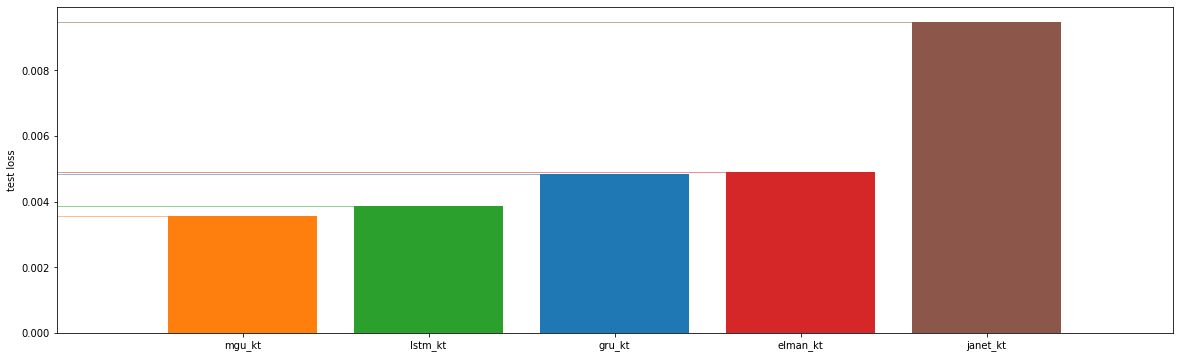

In [8]:
y = []
l = []
c = []
for k,v in test_loss.items():
    print(f'{k}:\t{v}')
    y.append(v)
    l.append(k)
    c.append(colors[k])

x= range(len(test_loss))

y = np.array(y)
l = np.array(l)
t = np.argsort(y)

plt.figure(figsize=(20,6))
plt.xlim(-1,len(x))

for i in t:
    plt.bar([i] , y[t[i]], color=c[t[i]] )
    plt.hlines(y[t[i]], -1, i, linestyles='solid', linewidth=0.5, color=c[t[i]])
plt.xticks(x, l[t])
plt.ylabel('test loss')
plt.show()

# Manual Testing

In [11]:
def predict(rnn, color, input_line, input_vector):
    xaxis = ds.classes.keys()
    
    rnn.return_last=False
    
    #inputs = tt.stack([ds.embed(s) for s in input_line])
    #print('diff=', inputs-input_vector)
    with tt.no_grad():
        output = rnn(tt.unsqueeze(input_vector, dim=0))
        #print(output.shape)
        
    
    output=tt.e**output.squeeze(0)
    #print(f'\n{inputs.shape=}:\n{inputs=}\n{output.shape=}:\n{output=}')
    #print(output)
    fig, ax = plt.subplots(1, len(output), figsize=(2*len(output),3), sharey=True, constrained_layout=True)
    class_keys = list(ds.classes.keys())
    for i,ts in enumerate(output):        
        ax[i].set_ylim(0,1)
        ax[i].set_title(f'{i+1}:{input_line[:i+1]}')
        pclass = tt.argmax(ts)
        pprob = ts[pclass]
        print( f'\t@{i+1} ::{input_line[:i+1]}: \t%{pprob:.2f} :: [#{pclass}, {class_keys[pclass]}]' ) #{tt.sum(ts)}
        ax[i].bar(xaxis, ts, color=color)
    plt.show()

> aaaaaa in class astr
Predict:elman_kt
	@1 ::a: 	%0.36 :: [#0, astr]
	@2 ::aa: 	%0.58 :: [#0, astr]
	@3 ::aaa: 	%0.82 :: [#2, mixed]
	@4 ::aaaa: 	%0.96 :: [#2, mixed]
	@5 ::aaaaa: 	%0.85 :: [#0, astr]
	@6 ::aaaaaa: 	%0.99 :: [#0, astr]


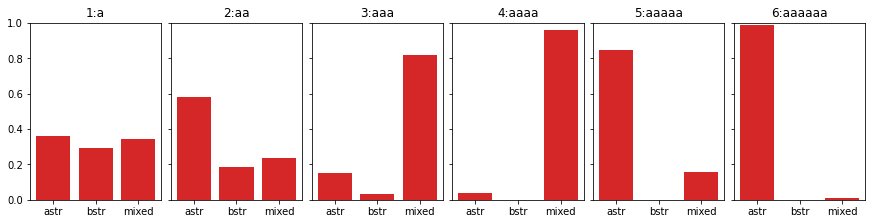

Predict:gru_kt
	@1 ::a: 	%0.35 :: [#2, mixed]
	@2 ::aa: 	%0.57 :: [#2, mixed]
	@3 ::aaa: 	%0.77 :: [#2, mixed]
	@4 ::aaaa: 	%0.74 :: [#2, mixed]
	@5 ::aaaaa: 	%0.70 :: [#0, astr]
	@6 ::aaaaaa: 	%0.98 :: [#0, astr]


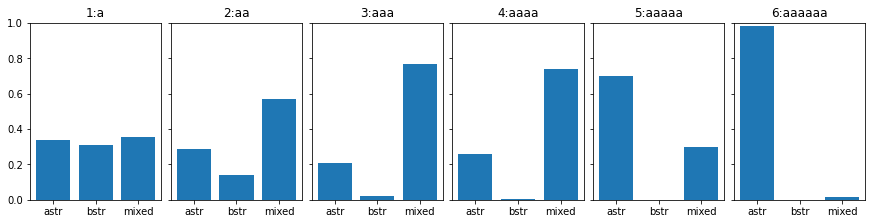

Predict:lstm_kt
	@1 ::a: 	%0.43 :: [#2, mixed]
	@2 ::aa: 	%0.52 :: [#2, mixed]
	@3 ::aaa: 	%0.57 :: [#2, mixed]
	@4 ::aaaa: 	%0.57 :: [#0, astr]
	@5 ::aaaaa: 	%0.88 :: [#0, astr]
	@6 ::aaaaaa: 	%0.99 :: [#0, astr]


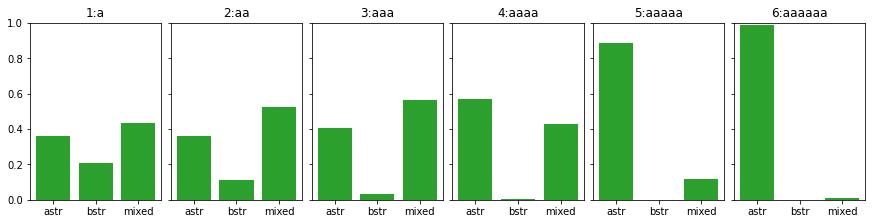

Predict:mgu_kt
	@1 ::a: 	%0.38 :: [#2, mixed]
	@2 ::aa: 	%0.53 :: [#2, mixed]
	@3 ::aaa: 	%0.64 :: [#2, mixed]
	@4 ::aaaa: 	%0.54 :: [#2, mixed]
	@5 ::aaaaa: 	%0.85 :: [#0, astr]
	@6 ::aaaaaa: 	%0.99 :: [#0, astr]


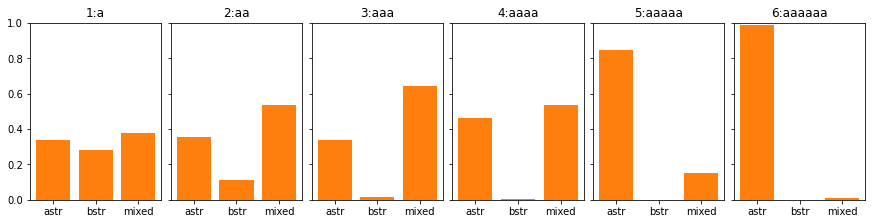

Predict:janet_kt
	@1 ::a: 	%0.35 :: [#0, astr]
	@2 ::aa: 	%0.48 :: [#2, mixed]
	@3 ::aaa: 	%0.69 :: [#2, mixed]
	@4 ::aaaa: 	%0.74 :: [#2, mixed]
	@5 ::aaaaa: 	%0.56 :: [#0, astr]
	@6 ::aaaaaa: 	%0.96 :: [#0, astr]


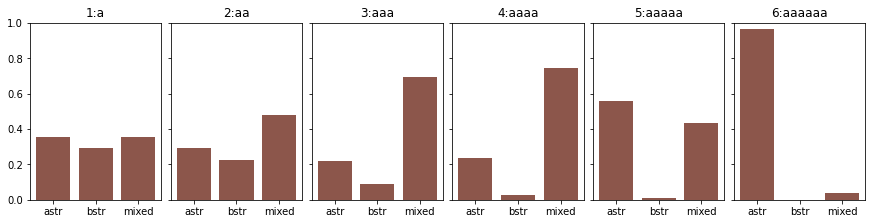

> bbbbbbb in class bstr
Predict:elman_kt
	@1 ::b: 	%0.34 :: [#2, mixed]
	@2 ::bb: 	%0.38 :: [#1, bstr]
	@3 ::bbb: 	%0.50 :: [#2, mixed]
	@4 ::bbbb: 	%0.53 :: [#1, bstr]
	@5 ::bbbbb: 	%0.88 :: [#1, bstr]
	@6 ::bbbbbb: 	%0.99 :: [#1, bstr]
	@7 ::bbbbbbb: 	%1.00 :: [#1, bstr]


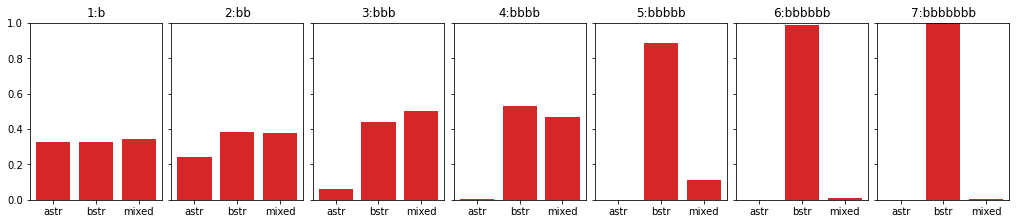

Predict:gru_kt
	@1 ::b: 	%0.38 :: [#2, mixed]
	@2 ::bb: 	%0.61 :: [#2, mixed]
	@3 ::bbb: 	%0.71 :: [#2, mixed]
	@4 ::bbbb: 	%0.55 :: [#2, mixed]
	@5 ::bbbbb: 	%0.86 :: [#1, bstr]
	@6 ::bbbbbb: 	%0.99 :: [#1, bstr]
	@7 ::bbbbbbb: 	%1.00 :: [#1, bstr]


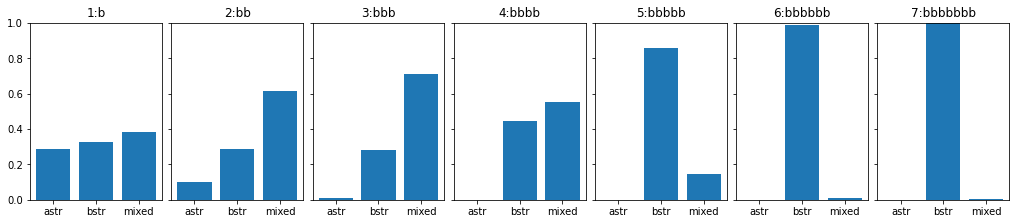

Predict:lstm_kt
	@1 ::b: 	%0.57 :: [#2, mixed]
	@2 ::bb: 	%0.73 :: [#2, mixed]
	@3 ::bbb: 	%0.77 :: [#2, mixed]
	@4 ::bbbb: 	%0.57 :: [#2, mixed]
	@5 ::bbbbb: 	%0.91 :: [#1, bstr]
	@6 ::bbbbbb: 	%0.99 :: [#1, bstr]
	@7 ::bbbbbbb: 	%1.00 :: [#1, bstr]


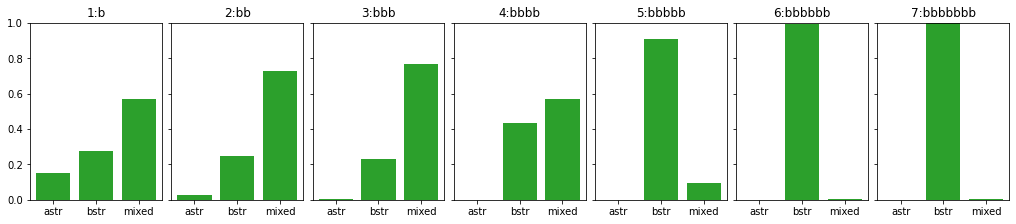

Predict:mgu_kt
	@1 ::b: 	%0.46 :: [#2, mixed]
	@2 ::bb: 	%0.68 :: [#2, mixed]
	@3 ::bbb: 	%0.72 :: [#2, mixed]
	@4 ::bbbb: 	%0.54 :: [#2, mixed]
	@5 ::bbbbb: 	%0.87 :: [#1, bstr]
	@6 ::bbbbbb: 	%0.99 :: [#1, bstr]
	@7 ::bbbbbbb: 	%1.00 :: [#1, bstr]


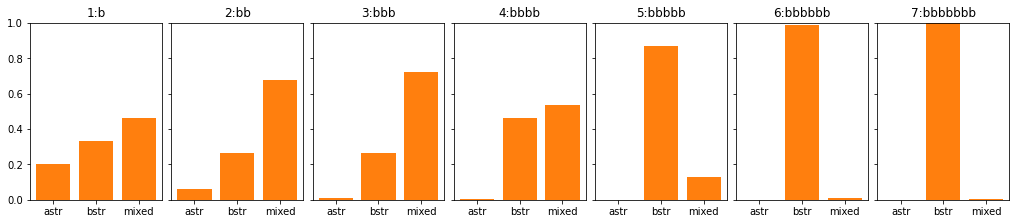

Predict:janet_kt
	@1 ::b: 	%0.38 :: [#2, mixed]
	@2 ::bb: 	%0.57 :: [#2, mixed]
	@3 ::bbb: 	%0.69 :: [#2, mixed]
	@4 ::bbbb: 	%0.62 :: [#2, mixed]
	@5 ::bbbbb: 	%0.71 :: [#1, bstr]
	@6 ::bbbbbb: 	%0.97 :: [#1, bstr]
	@7 ::bbbbbbb: 	%1.00 :: [#1, bstr]


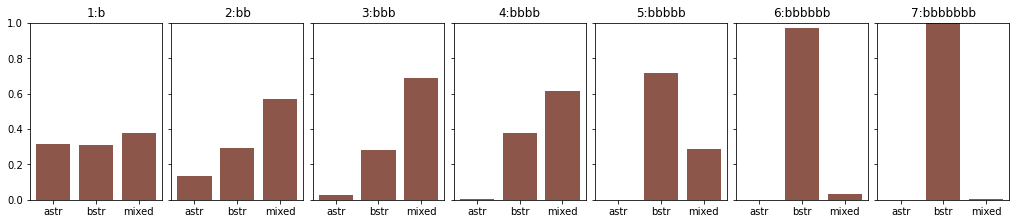

> babaabb in class mixed
Predict:elman_kt
	@1 ::b: 	%0.34 :: [#2, mixed]
	@2 ::ba: 	%0.38 :: [#2, mixed]
	@3 ::bab: 	%0.55 :: [#2, mixed]
	@4 ::baba: 	%0.97 :: [#2, mixed]
	@5 ::babaa: 	%0.97 :: [#2, mixed]
	@6 ::babaab: 	%0.95 :: [#2, mixed]
	@7 ::babaabb: 	%1.00 :: [#2, mixed]


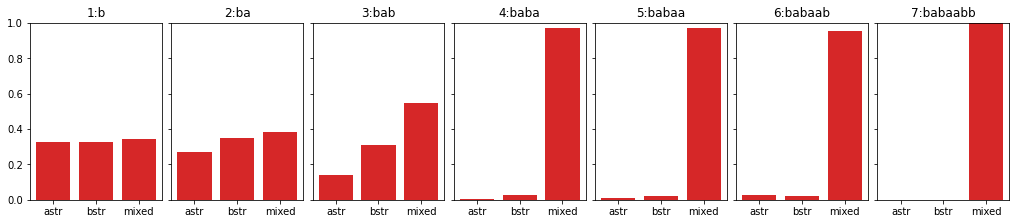

Predict:gru_kt
	@1 ::b: 	%0.38 :: [#2, mixed]
	@2 ::ba: 	%0.61 :: [#2, mixed]
	@3 ::bab: 	%0.87 :: [#2, mixed]
	@4 ::baba: 	%0.97 :: [#2, mixed]
	@5 ::babaa: 	%1.00 :: [#2, mixed]
	@6 ::babaab: 	%1.00 :: [#2, mixed]
	@7 ::babaabb: 	%1.00 :: [#2, mixed]


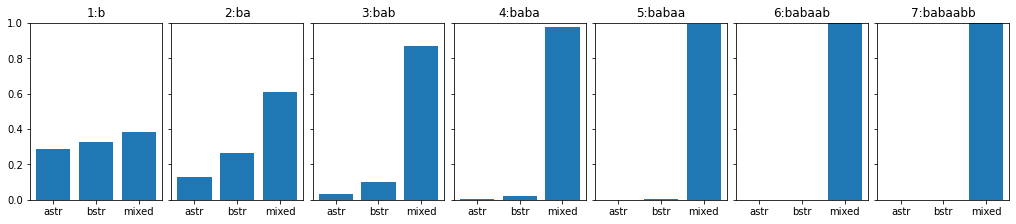

Predict:lstm_kt
	@1 ::b: 	%0.57 :: [#2, mixed]
	@2 ::ba: 	%0.69 :: [#2, mixed]
	@3 ::bab: 	%0.88 :: [#2, mixed]
	@4 ::baba: 	%0.96 :: [#2, mixed]
	@5 ::babaa: 	%0.99 :: [#2, mixed]
	@6 ::babaab: 	%1.00 :: [#2, mixed]
	@7 ::babaabb: 	%1.00 :: [#2, mixed]


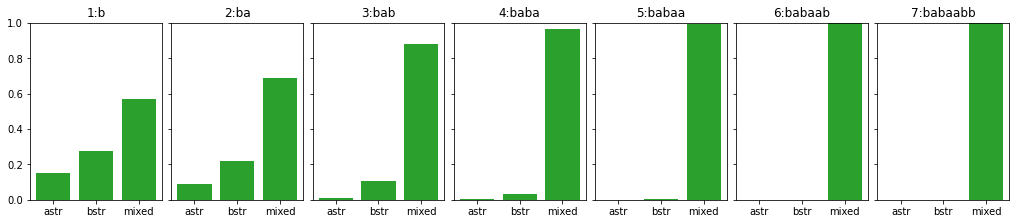

Predict:mgu_kt
	@1 ::b: 	%0.46 :: [#2, mixed]
	@2 ::ba: 	%0.69 :: [#2, mixed]
	@3 ::bab: 	%0.90 :: [#2, mixed]
	@4 ::baba: 	%0.98 :: [#2, mixed]
	@5 ::babaa: 	%1.00 :: [#2, mixed]
	@6 ::babaab: 	%1.00 :: [#2, mixed]
	@7 ::babaabb: 	%1.00 :: [#2, mixed]


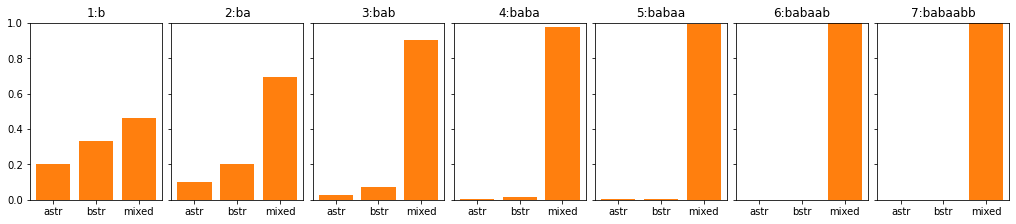

Predict:janet_kt
	@1 ::b: 	%0.38 :: [#2, mixed]
	@2 ::ba: 	%0.57 :: [#2, mixed]
	@3 ::bab: 	%0.82 :: [#2, mixed]
	@4 ::baba: 	%0.95 :: [#2, mixed]
	@5 ::babaa: 	%0.99 :: [#2, mixed]
	@6 ::babaab: 	%1.00 :: [#2, mixed]
	@7 ::babaabb: 	%1.00 :: [#2, mixed]


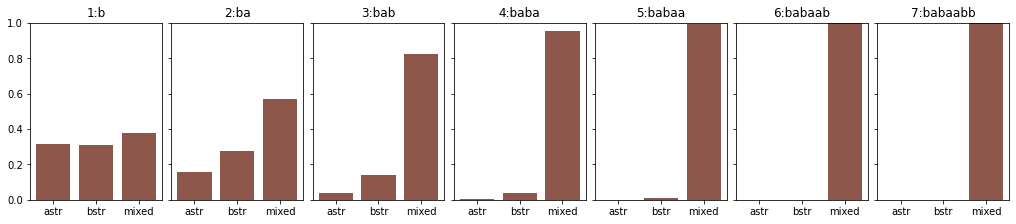

In [12]:



for c in ds.classes:

    index, (xv, yv), (xs, ys) = ds.get_word_from_class(c)
    #print(f'\n\nPredicting @{index} from class: {ys}[{yv=}] =>> {xs}[{xv=}] ')
    print(f'> {xs} in class {ys}')
    for key,model in networks.items():
        print(f'Predict:{key}')
        predict(model, colors[key], xs, xv)
